In [1]:
import os
import sys
import xarray as xr
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append("/home/khanalp/code/PhD")
from utils.utils import read_csv_file_with_station_name

**I choose these two sites, because they both had very good model simulations.**

In [3]:
station_grassland = "DE-RuR"
station_forest = "DE-Tha"

In [4]:
# Paths to the file locations
path_input = "/home/khanalp/data/processed/input_pystemmus"
path_model_output = "/home/khanalp/data/processed/output_pystemmus"
path_resistance = "/home/khanalp/resistancecheck"
path_insitu_flux = "/home/khanalp/data/processed/insituflux_with_qc"
path_ICOS = "/home/khanalp/data/ICOS2020"
path_model_output_forest = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/DE-Tha/output/DE-Tha_2024-04-23-1419/fluxes.csv"
path_model_output_grassland = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/DE-RuR/output/DE-RuR_2024-05-01-1618/fluxes.csv"

In [5]:
# Function to get file locations
def get_files_for_station(station_name):
    file_input = [f for f in os.listdir(path_input) if f.endswith(".nc") and station_name in f]
    file_output = [f for f in os.listdir(path_model_output) if f.endswith(".nc") and station_name in f]
    file_resistance = [f for f in os.listdir(path_resistance) if f.endswith(".csv") and station_name in f]
    file_insitu = [f for f in os.listdir(path_insitu_flux) if f.endswith(".nc") and station_name in f]
    return file_input, file_output, file_resistance, file_insitu

In [6]:
# Function to load data
def load_data(station_name, path_model_output_flux):
    file_input, file_output, file_resistance, file_insitu = get_files_for_station(station_name)
    xr_input = xr.open_dataset(os.path.join(path_input, file_input[0]))
    xr_output = xr.open_dataset(os.path.join(path_model_output, file_output[0]))
    df_resistance = pd.read_csv(os.path.join(path_resistance, file_resistance[0]))
    xr_insitu = xr.open_dataset(os.path.join(path_insitu_flux, file_insitu[0]))
    df_insitu = read_csv_file_with_station_name(path_ICOS, station_name)
    df_fluxes_output = pd.read_csv(path_model_output_flux)
    return xr_input, xr_output, df_resistance, xr_insitu, df_insitu, df_fluxes_output

# Load data for grassland
xr_input_grassland, xr_output_grassland, df_resistance_grassland, xr_insitu_grassland, df_insitu_grassland, df_fluxes_output_grassland = load_data(station_grassland, path_model_output_grassland)

# Load data for forest
xr_input_forest, xr_output_forest, df_resistance_forest, xr_insitu_forest, df_insitu_forest, df_fluxes_output_forest = load_data(station_forest, path_model_output_forest)

/home/khanalp/tmp/ipykernel_914626/2688491187.py:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fluxes_output = pd.read_csv(path_model_output_flux)
/home/khanalp/tmp/ipykernel_914626/2688491187.py:9: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fluxes_output = pd.read_csv(path_model_output_flux)


In [7]:
# JUst to get proper time format in the df_fluxes file
def process_fluxes(df_fluxes_output, xr_input):
    df_fluxes_model = df_fluxes_output[1:]
    df_fluxes_model.time = pd.to_datetime(xr_input.time)
    df_fluxes_model.index = df_fluxes_model.time
    df_fluxes_model = df_fluxes_model.apply(pd.to_numeric, errors='coerce')
    return df_fluxes_model

# Process fluxes for grassland
df_fluxes_model_grassland = process_fluxes(df_fluxes_output_grassland, xr_input_grassland)

# Process fluxes for forest
df_fluxes_model_forest = process_fluxes(df_fluxes_output_forest, xr_input_forest)

/home/khanalp/tmp/ipykernel_914626/1010384922.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_fluxes_model.time = pd.to_datetime(xr_input.time)
/home/khanalp/tmp/ipykernel_914626/1010384922.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_fluxes_model.time = pd.to_datetime(xr_input.time)


In [8]:
# For insitu processing 
def process_insitu_data(df_insitu):
    df_insitu["time"] = pd.to_datetime(df_insitu["TIMESTAMP_START"], format='%Y%m%d%H%M')
    df_insitu.index = df_insitu["time"]
    return df_insitu

# Process insitu data for grassland
df_insitu_grassland = process_insitu_data(df_insitu_grassland)

# Process insitu data for forest
df_insitu_forest = process_insitu_data(df_insitu_forest)

In [9]:
def process_resistance_data(df_resistance, xr_input):
    start_time = xr_input.time.values[0]
    frequency = pd.infer_freq(xr_input.time.to_index())
    time_series = pd.date_range(start=start_time, periods=len(df_resistance), freq=frequency)
    df_resistance["time"] = time_series
    df_resistance.set_index("time", inplace=True)
    return df_resistance

# Process resistance data for grassland
df_resistance_grassland = process_resistance_data(df_resistance_grassland, xr_input_grassland)

# Process resistance data for forest
df_resistance_forest = process_resistance_data(df_resistance_forest, xr_input_forest)


**I select different time periods for the two locations randomly based on the available model run period**

In [10]:
start_time_forest = pd.to_datetime("2005-07-10")
end_time_forest = pd.to_datetime("2005-07-17")
start_time_grassland = pd.to_datetime("2013-07-10")
end_time_grassland = pd.to_datetime("2013-07-17")

In [11]:
def select_data(df_resistance, df_insitu, df_fluxes_model, xr_input, xr_output, xr_insitu, start_time, end_time):
    df_resistance_selected = df_resistance.loc[start_time:end_time]
    df_insitu_selected = df_insitu.loc[start_time:end_time]
    df_fluxes_model_selected = df_fluxes_model.loc[start_time:end_time]
    xr_input_selected = xr_input.sel(time=slice(start_time, end_time))
    xr_output_selected = xr_output.sel(time=slice(start_time, end_time))
    xr_insitu_selected = xr_insitu.sel(time=slice(start_time, end_time))
    return df_resistance_selected, df_insitu_selected, df_fluxes_model_selected, xr_input_selected, xr_output_selected, xr_insitu_selected

df_resistance_selected_forest, df_insitu_selected_forest, df_fluxes_model_selected_forest, xr_input_selected_forest, xr_output_selected_forest, xr_insitu_selected_forest = select_data(
    df_resistance_forest, df_insitu_forest, df_fluxes_model_forest, xr_input_forest, xr_output_forest, xr_insitu_forest, start_time_forest, end_time_forest)
df_resistance_selected_grassland, df_insitu_selected_grassland, df_fluxes_model_selected_grassland, xr_input_selected_grassland, xr_output_selected_grassland, xr_insitu_selected_grassland = select_data(
    df_resistance_grassland, df_insitu_grassland, df_fluxes_model_grassland, xr_input_grassland, xr_output_grassland, xr_insitu_grassland, start_time_grassland, end_time_grassland)


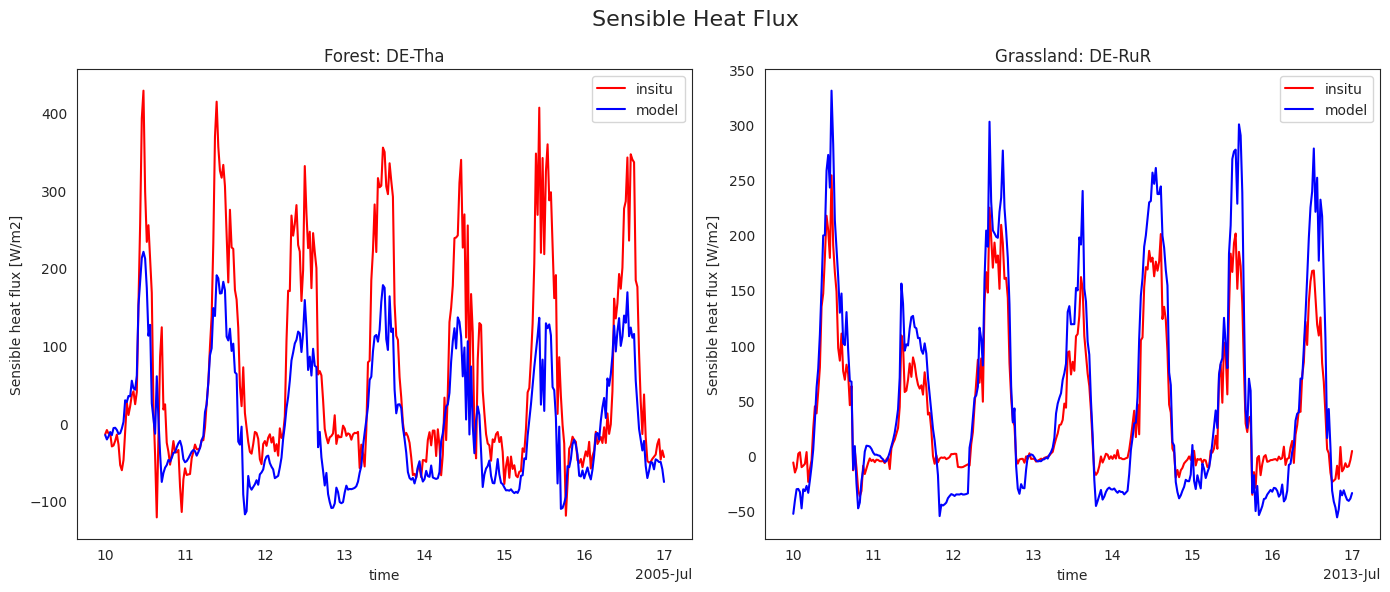

In [12]:
# xr_insitu_selected.Qh_cor.plot(color="red", label = "insitu")
sns.set_style("white")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
xr_insitu_selected_forest.Qh_cor.plot(ax=axes[0], color="red", label="insitu")
xr_output_selected_forest.Qh.plot(ax=axes[0], color="blue", label="model")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot for grassland
xr_insitu_selected_grassland.Qh_cor.plot(ax=axes[1], color="red", label="insitu")
xr_output_selected_grassland.Qh.plot(ax=axes[1], color="blue", label="model")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Sensible Heat Flux', fontsize=16)
plt.tight_layout()
plt.show()

**We can notice, model underestimates sensible heat flux for the forest, while overestimates for the grassland, during peak hours.**

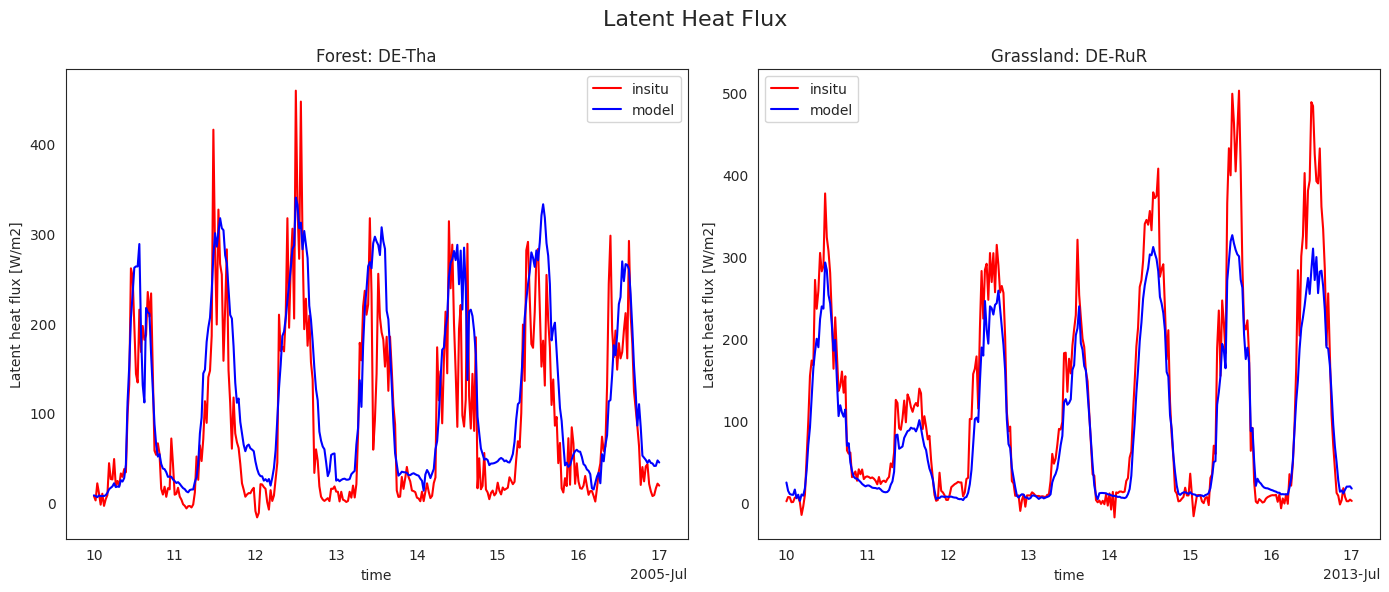

In [13]:

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
xr_insitu_selected_forest.Qle_cor.plot(ax=axes[0], color="red", label="insitu")
xr_output_selected_forest.Qle.plot(ax=axes[0], color="blue", label="model")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot for grassland
xr_insitu_selected_grassland.Qle_cor.plot(ax=axes[1], color="red", label="insitu")
xr_output_selected_grassland.Qle.plot(ax=axes[1], color="blue", label="model")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Latent Heat Flux', fontsize=16)
plt.tight_layout()
plt.show()

**While this is not necessary I plot the latent heat flux, in general model well watches the observations, while slightly underestimating peak latent heat flux for grassland site.**

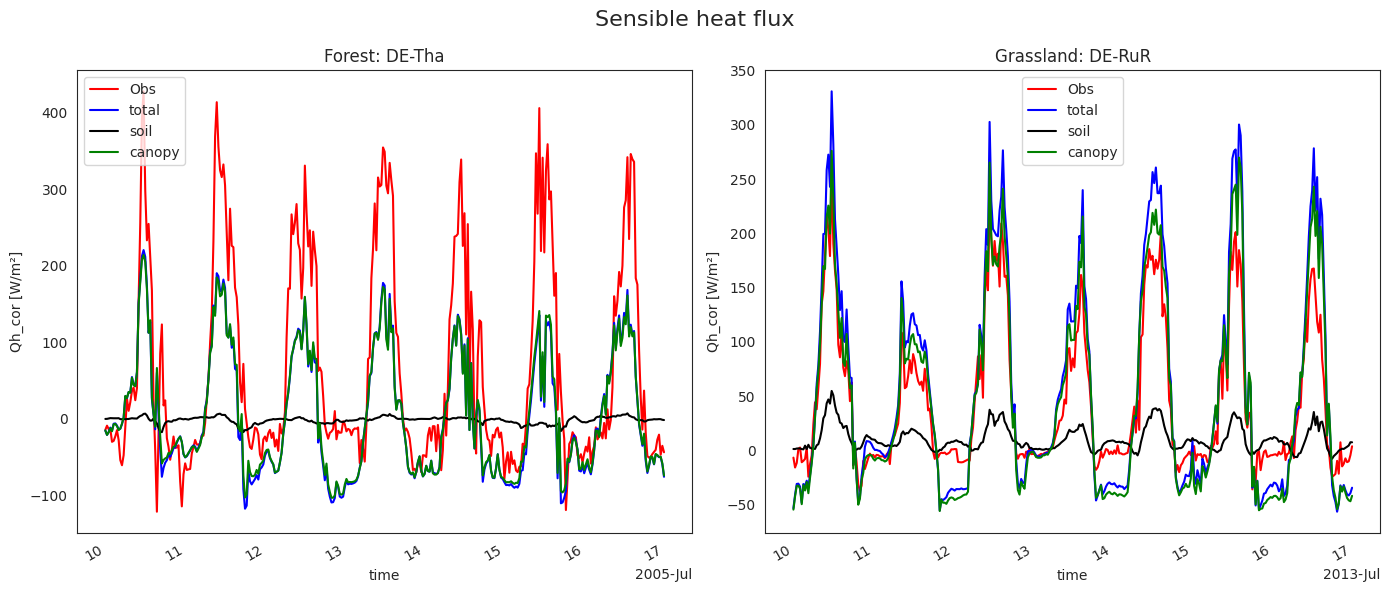

In [14]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
xr_insitu_selected_forest.Qh_cor.plot(ax=axes[0], color="red", label="Obs")
df_fluxes_model_selected_forest.Htot.plot(ax=axes[0], color="blue", label="total")
df_fluxes_model_selected_forest.Hstot.plot(ax=axes[0], color="black", label="soil")
df_fluxes_model_selected_forest.Hctot.plot(ax=axes[0], color="green", label="canopy")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot for grassland
xr_insitu_selected_grassland.Qh_cor.plot(ax=axes[1], color="red", label="Obs")
df_fluxes_model_selected_grassland.Htot.plot(ax=axes[1], color="blue", label="total")
df_fluxes_model_selected_grassland.Hstot.plot(ax=axes[1], color="black", label="soil")
df_fluxes_model_selected_grassland.Hctot.plot(ax=axes[1], color="green", label="canopy")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Sensible heat flux', fontsize=16)
plt.tight_layout()
plt.show()


**I think this is interesting plot because**
* For forest, the canopy heat flux contributes (green) most to the total heat flux (blue) compared to the soil heat flux (black). 
* Interestingly, for grassland, the canopy heat flux (green) is already higher than the observed total flux in the EC system (red).

/home/khanalp/tmp/ipykernel_914626/3382688184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resistance_selected_forest["total_canopy_aerodynamic"] = df_resistance_selected_forest[["r_rac", "rar", "rai"]].sum(axis=1)
/home/khanalp/tmp/ipykernel_914626/3382688184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resistance_selected_forest["total_canopy"] = df_resistance_selected_forest[["rbc", "r_rac", "rar", "rai"]].sum(axis=1)
/home/khanalp/tmp/ipykernel_914626/3382688184.py:6: SettingWithCopy

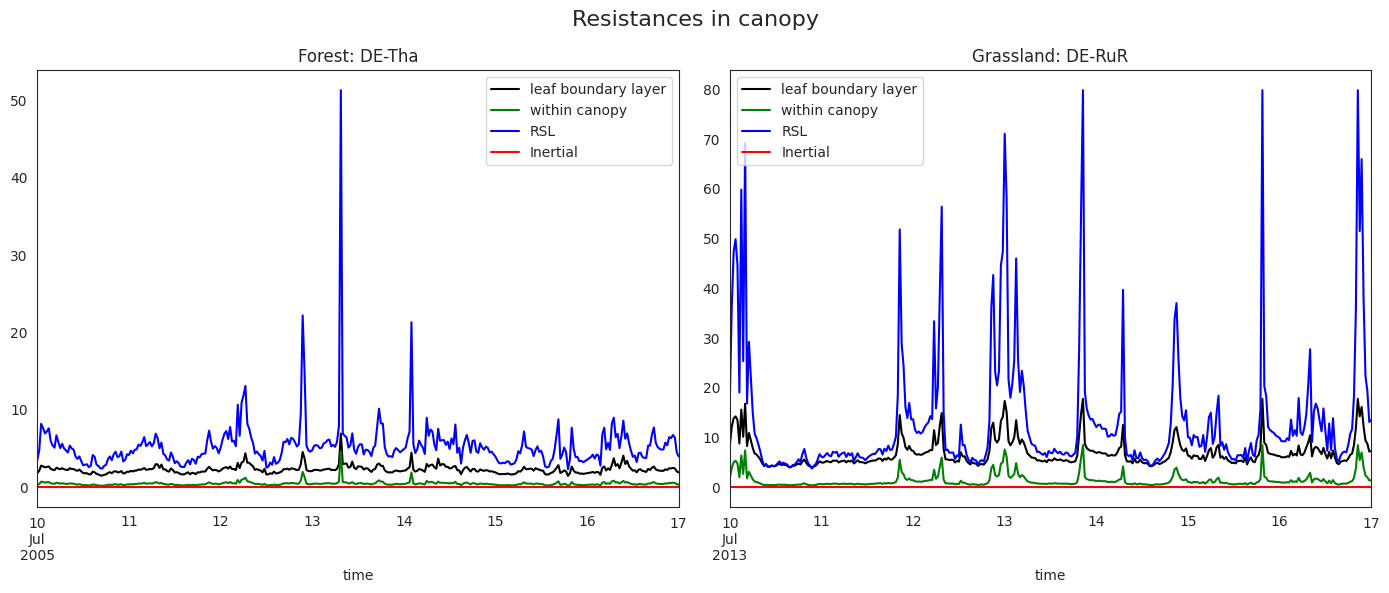

In [15]:
# For canopy
# Sum of all resistances for forest
df_resistance_selected_forest["total_canopy_aerodynamic"] = df_resistance_selected_forest[["r_rac", "rar", "rai"]].sum(axis=1)
df_resistance_selected_forest["total_canopy"] = df_resistance_selected_forest[["rbc", "r_rac", "rar", "rai"]].sum(axis=1)
# Sum of all resistances for grassland
df_resistance_selected_grassland["total_canopy_aerodynamic"] = df_resistance_selected_grassland[["r_rac", "rar", "rai"]].sum(axis=1)
df_resistance_selected_grassland["total_canopy"] = df_resistance_selected_grassland[["rbc", "r_rac", "rar", "rai"]].sum(axis=1)
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
df_resistance_selected_forest["rbc"].plot(ax = axes[0], color = 'black', label = "leaf boundary layer")
df_resistance_selected_forest["r_rac"].plot(ax = axes[0], color = 'green', label = "within canopy")
df_resistance_selected_forest["rar"].plot(ax = axes[0], color = 'blue', label = "RSL")
df_resistance_selected_forest["rai"].plot(ax = axes[0], color = 'red', label = "Inertial")
# df_resistance_selected_forest["total_canopy"].plot(ax=axes[0], color='orange', label="total")
axes[0].set_title('Forest: DE-Tha')
# axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

# Plot for grassland
# Plot for forest
df_resistance_selected_grassland["rbc"].plot(ax = axes[1], color = 'black', label = "leaf boundary layer")
df_resistance_selected_grassland["r_rac"].plot(ax = axes[1], color = 'green', label = "within canopy")
df_resistance_selected_grassland["rar"].plot(ax = axes[1], color = 'blue', label = "RSL")
df_resistance_selected_grassland["rai"].plot(ax = axes[1], color = 'red', label = "Inertial")
# df_resistance_selected_grassland["total_canopy"].plot(ax=axes[1], color='orange', label="total")
axes[1].set_title('Grassland: DE-RuR')
# axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
fig.suptitle('Resistances in canopy', fontsize=16)
plt.tight_layout()
plt.show()



# (df_resistance_selected["raa"]+df_resistance_selected["rws"]+df_resistance_selected["rbs"]).plot(label="total")
# df_resistance_selected["raa"].plot(label="rac")
# # df_resistance_selected["rar"].plot(label="rar")
# df_resistance_selected["rws"].plot(label="rws")

# df_resistance_selected["rbs"].plot(label="rbs")
# plt.legend()

**My observations compared to Wallace and Verhoef Figure 8.6 are:**
* Note thatthe total canopy resistance to sensible heat flux is sum of all the resistance in the above plot.
* 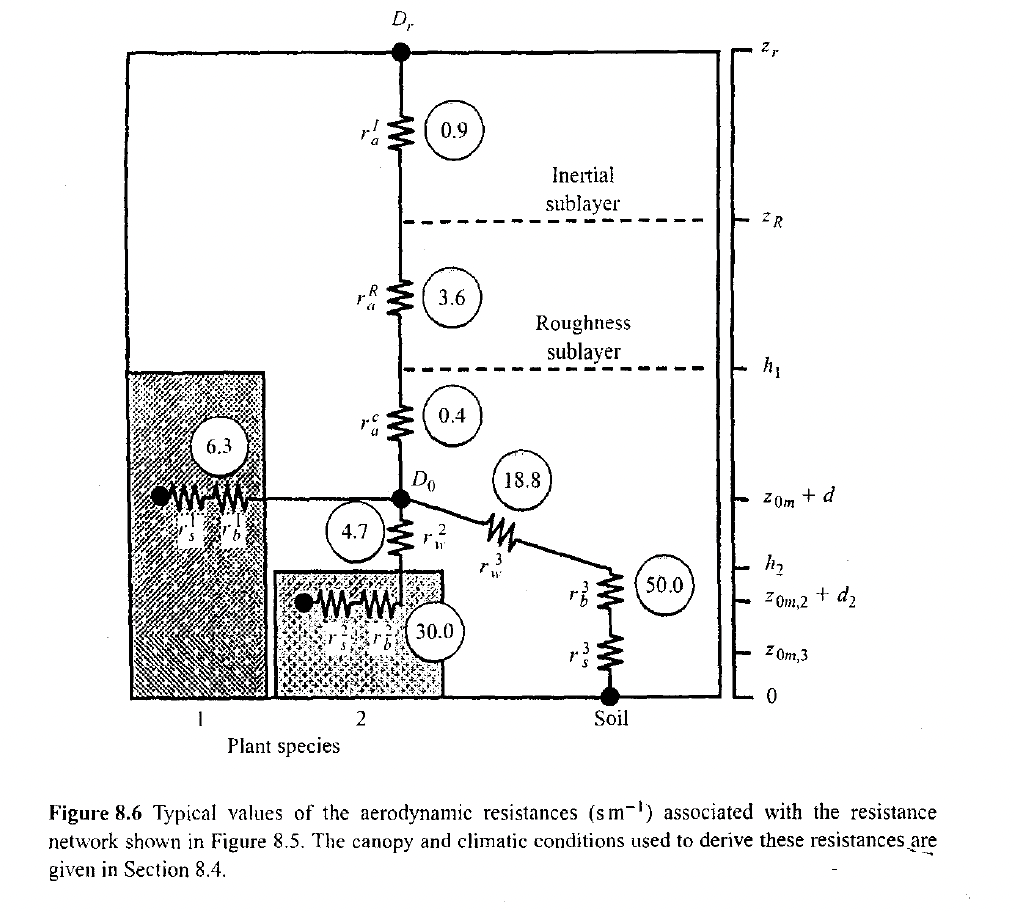
* The resistance from RSL is much higher than the leaf boundary layer resistance compared to the WallaceandVerhoef. <span style="color: red;">Is this the case?</span>
* Currently, the boundary layer resistance is calculated by using $rbc = \frac{70}{LAI} \sqrt{\frac{w}{uz0}}$, wehre, w is leaf width and uz0 is windspeed at z0m from exponetial profile. Once we replace it with the wind speed at each layer, this will change.
* <span style="color: red;">One thing I did not grasp is on line 319-320 of ebal.m all these resistances are multiplied by (LAI+1) before passing it into the heatfluxes.m. Do you know why we do this?</span> like $rac = (LAI + 1) \times (raa + rawc)$



/home/khanalp/tmp/ipykernel_914626/606787880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resistance_selected_forest["total_soil"] = df_resistance_selected_forest[["rbs", "rws","r_rac", "rar", "rai"]].sum(axis=1)
/home/khanalp/tmp/ipykernel_914626/606787880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resistance_selected_grassland["total_soil"] = df_resistance_selected_grassland[["rbs", "rws","r_rac", "rar", "rai"]].sum(axis=1)


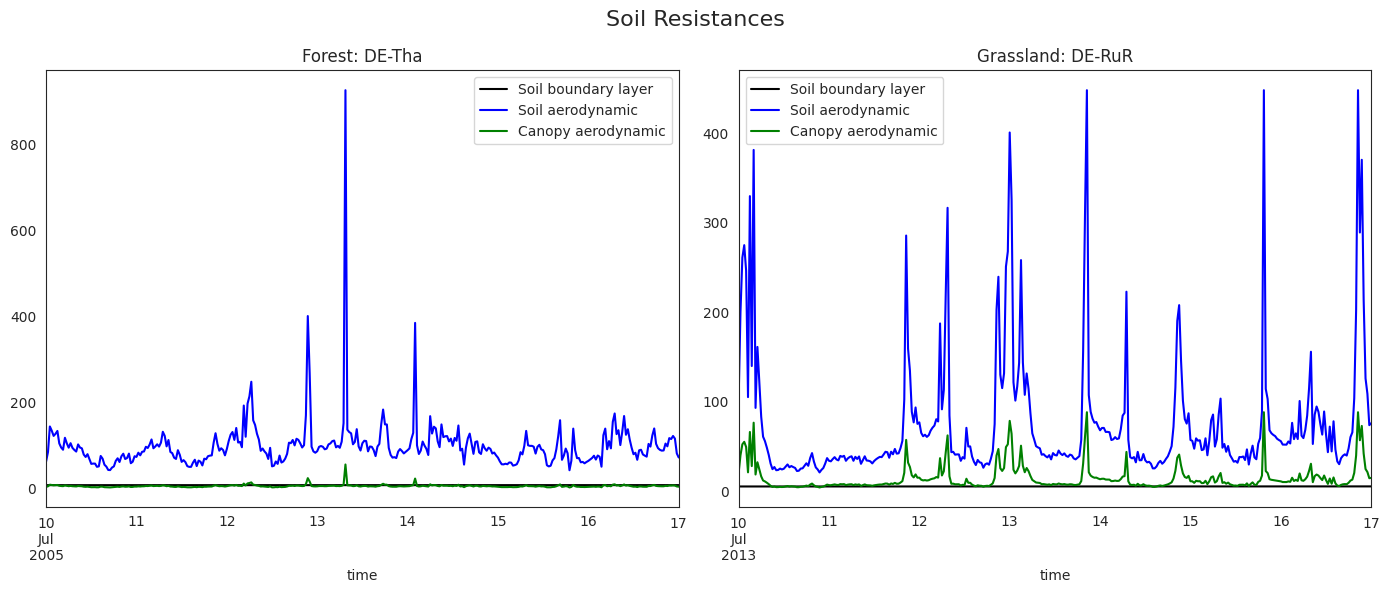

In [16]:
# For soil
# Sum of all resistances for forest
df_resistance_selected_forest["total_soil"] = df_resistance_selected_forest[["rbs", "rws","r_rac", "rar", "rai"]].sum(axis=1)

# Sum of all resistances for grassland
df_resistance_selected_grassland["total_soil"] = df_resistance_selected_grassland[["rbs", "rws","r_rac", "rar", "rai"]].sum(axis=1)
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
df_resistance_selected_forest["rbs"].plot(ax = axes[0], color = 'black', label = "Soil boundary layer")
df_resistance_selected_forest["rws"].plot(ax = axes[0], color = 'blue', label = "Soil aerodynamic ")
df_resistance_selected_forest["total_canopy_aerodynamic"].plot(ax = axes[0], color = 'green', label = "Canopy aerodynamic")
# df_resistance_selected_forest["total_soil"].plot(ax=axes[0], color='orange', label="total")
axes[0].set_title('Forest: DE-Tha')
# axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

# Plot for grassland
# Plot for forest
df_resistance_selected_grassland["rbs"].plot(ax = axes[1], color = 'black', label = "Soil boundary layer")
df_resistance_selected_grassland["rws"].plot(ax = axes[1], color = 'blue', label = "Soil aerodynamic ")
df_resistance_selected_grassland["total_canopy_aerodynamic"].plot(ax = axes[1], color = 'green', label = "Canopy aerodynamic")
# df_resistance_selected_grassland["total_soil"].plot(ax=axes[1], color='orange', label="total")
axes[1].set_title('Grassland: DE-RuR')
# axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
fig.suptitle('Soil Resistances', fontsize=16)
plt.tight_layout()
plt.show()


**My observations. Note the total soil resistance is the sum of all the resistances.**
* The soil aerodynamic resistance is much higher than any other resistance. This is calculated as variable $r_{ws}$ inside resistances.m (line131). This is calculated as:
$$
r_{ws} = h \frac{\sinh(n)}{n K_h} 
\left( \log \left( \frac{e^{n \frac{z_{0m} + d}{h}} - 1}{e^{n \frac{z_{0m} + d}{h}} + 1} \right) 
- \log \left( \frac{e^{n \frac{0.01}{h}} - 1}{e^{n \frac{0.01}{h}} + 1} \right) \right)
$$
* This basically explains why soil heat flux in the forest is much lower. (resistance to soil heat flux is much higher.)



# Now on the temperature part

In [17]:
# Calculate T_LWout for grassland
emmisivity = 0.98
df_insitu_selected_grassland['T_LWout'] = np.power(df_insitu_selected_grassland['LW_OUT'] / (5.67e-8 * emmisivity), 0.25)

# Calculate T_LWout for forest
df_insitu_selected_forest['T_LWout'] = np.power(df_insitu_selected_forest['LW_OUT'] / (5.67e-8 * emmisivity), 0.25)

/home/khanalp/tmp/ipykernel_914626/1596607406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected_grassland['T_LWout'] = np.power(df_insitu_selected_grassland['LW_OUT'] / (5.67e-8 * emmisivity), 0.25)
/home/khanalp/tmp/ipykernel_914626/1596607406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insitu_selected_forest['T_LWout'] = np.power(df_insitu_selected_forest['LW_OUT'] / (5.67e-8 * emmisivity), 0.25)


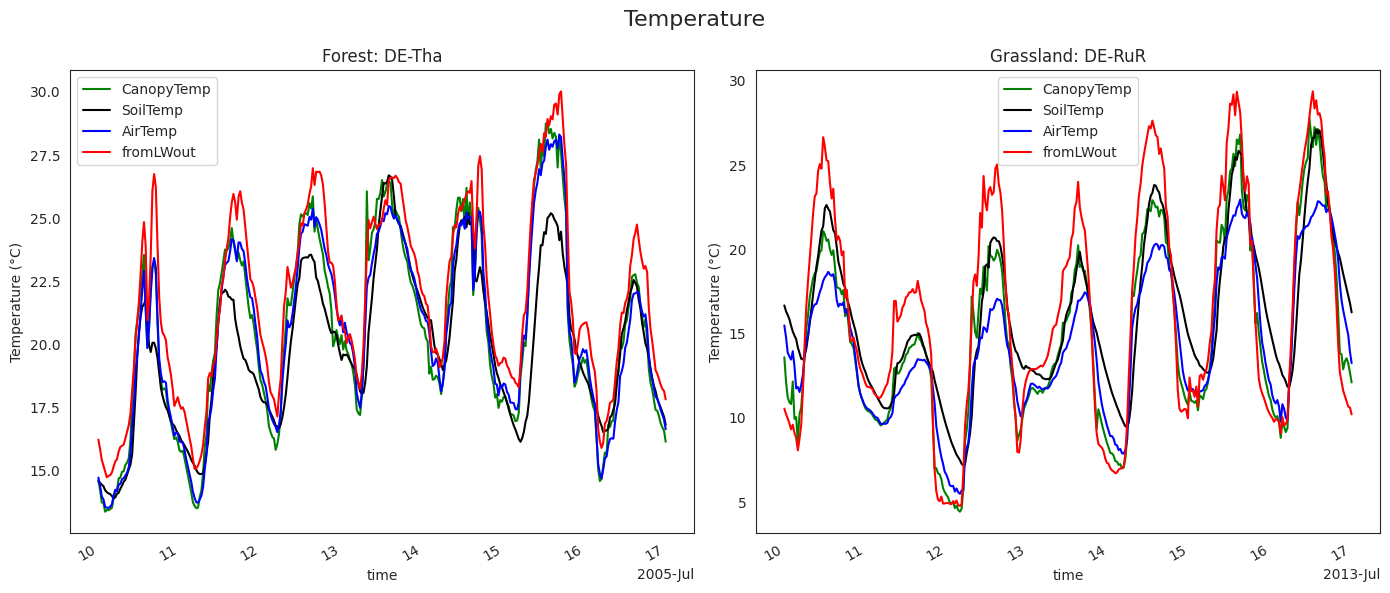

In [18]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
xr_output_selected_forest.VegT.plot(ax=axes[0], color="green", label="CanopyTemp")
(xr_output_selected_forest.SoilTemp[:, 0, :, :] - 273.15).plot(ax=axes[0], color="black", label="SoilTemp")
xr_output_selected_forest.Tair.plot(ax=axes[0], color="blue", label="AirTemp")
(df_insitu_selected_forest['T_LWout'] - 273.15).plot(ax=axes[0], color="red", label="fromLWout")
axes[0].set_title('Forest: DE-Tha')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

# Plot for grassland
xr_output_selected_grassland.VegT.plot(ax=axes[1], color="green", label="CanopyTemp")
(xr_output_selected_grassland.SoilTemp[:, 0, :, :] - 273.15).plot(ax=axes[1], color="black", label="SoilTemp")
xr_output_selected_grassland.Tair.plot(ax=axes[1], color="blue", label="AirTemp")
(df_insitu_selected_grassland['T_LWout'] - 273.15).plot(ax=axes[1], color="red", label="fromLWout")
axes[1].set_title('Grassland: DE-RuR')
axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
fig.suptitle('Temperature', fontsize=16)
plt.tight_layout()
plt.show()


**My observations**
* In forest, the soil temperature is around 2.5 degrees lower than the canopy temperature in peak period. The canopy temperature is almost same to the air temperature.
* In grassland, both canopy and soil temperature are 2 degrees higher than air temperature in peak period. 
* I calculated the max temperature limit from Longwave outgoing from insitu data using Stefan Boltzman equation and assuming emissivity = 0.98.

# Because much of this calculation is impacted by LAI and wind speed(u), I plot it down here.

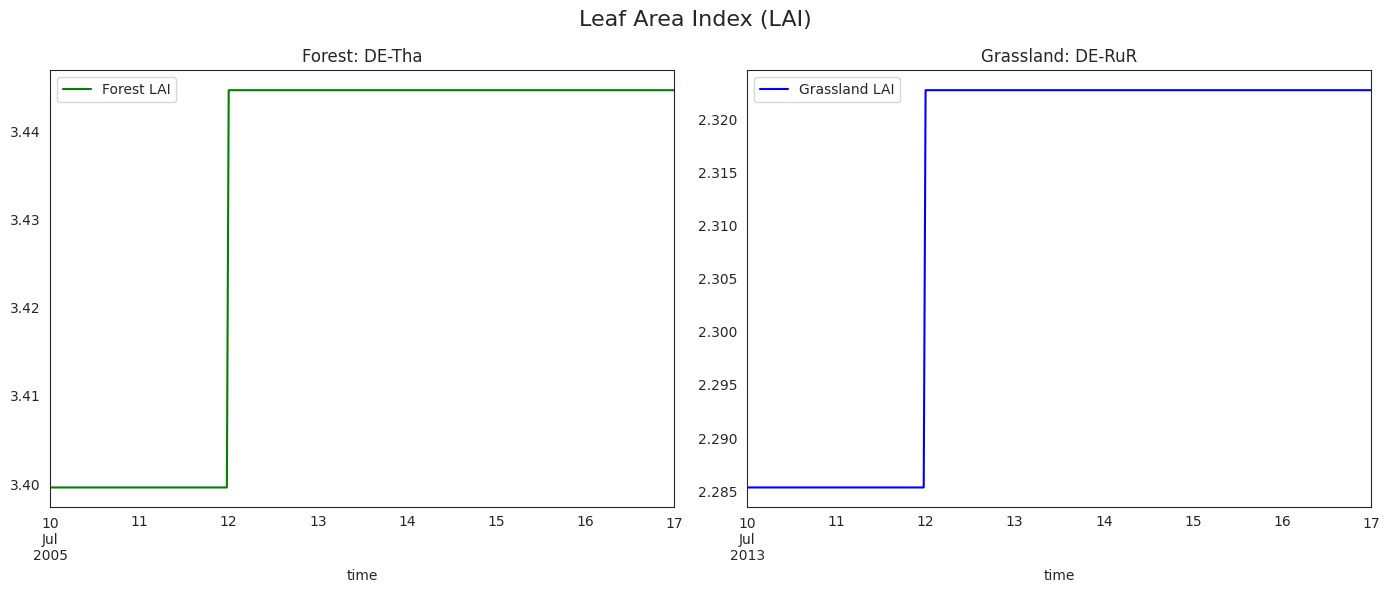

In [19]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot LAI for forest
df_resistance_selected_forest['LAI'].plot(ax=axes[0], color="green", label="Forest LAI")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot LAI for grassland
df_resistance_selected_grassland['LAI'].plot(ax=axes[1], color="blue", label="Grassland LAI")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Leaf Area Index (LAI)', fontsize=16)
plt.tight_layout()
plt.show()

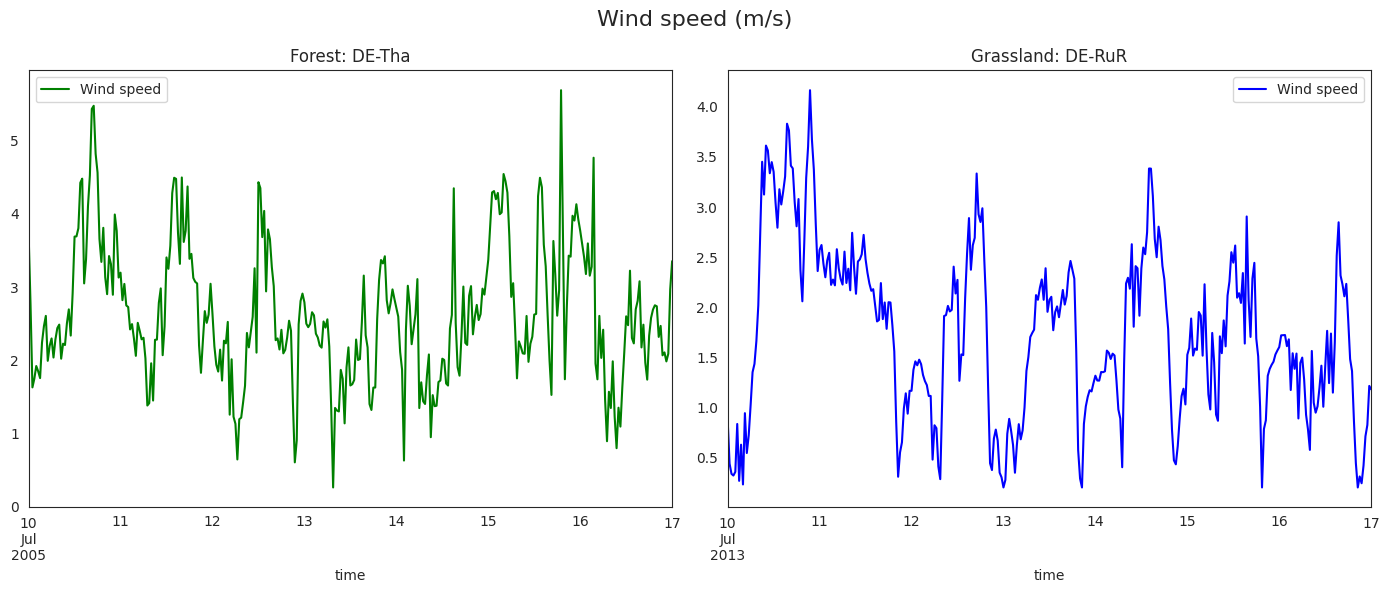

In [20]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot LAI for forest
df_resistance_selected_forest['u'].plot(ax=axes[0], color="green", label="Wind speed")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot LAI for grassland
df_resistance_selected_grassland['u'].plot(ax=axes[1], color="blue", label="Wind speed")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Wind speed (m/s)', fontsize=16)
plt.tight_layout()
plt.show()

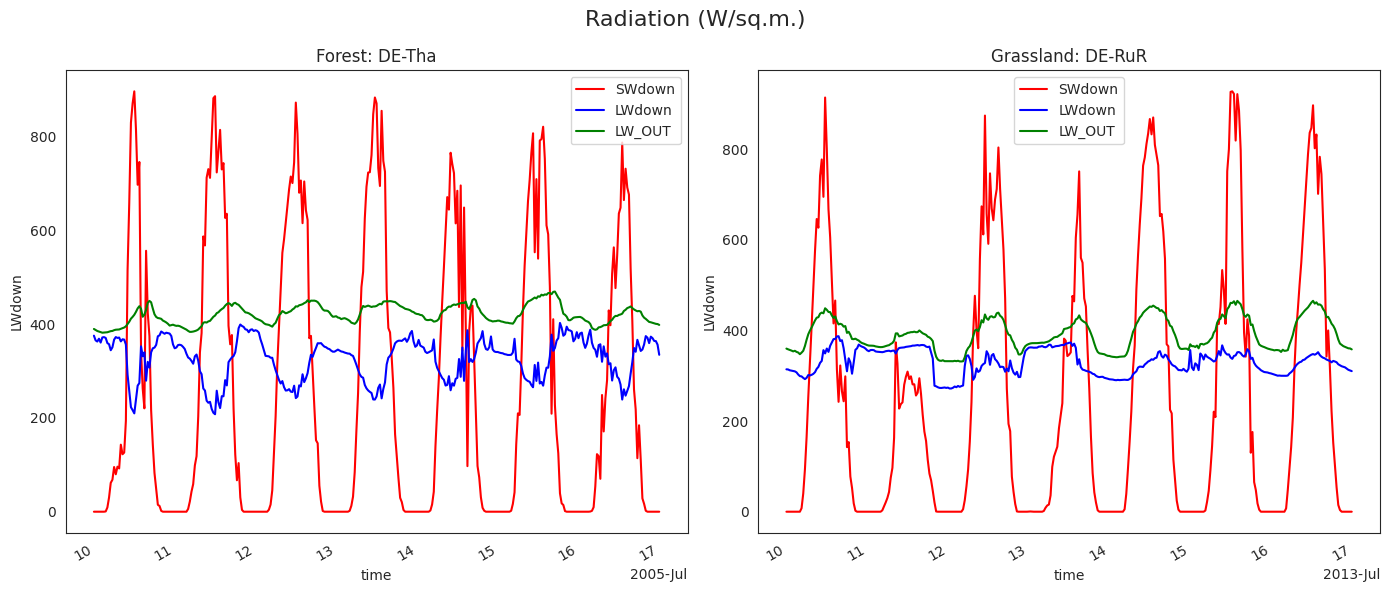

In [22]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot for forest
xr_input_selected_forest.SWdown.plot(ax=axes[0], color="red", label="SWdown")
xr_input_selected_forest.LWdown.plot(ax=axes[0], color="blue", label="LWdown")
df_insitu_selected_forest.LW_OUT.plot(ax=axes[0], color="green", label="LW_OUT")
axes[0].set_title('Forest: DE-Tha')
axes[0].legend()

# Plot for grassland
xr_input_selected_grassland.SWdown.plot(ax=axes[1], color="red", label="SWdown")
xr_input_selected_grassland.LWdown.plot(ax=axes[1], color="blue", label="LWdown")
df_insitu_selected_grassland.LW_OUT.plot(ax=axes[1], color="green", label="LW_OUT")
axes[1].set_title('Grassland: DE-RuR')
axes[1].legend()
fig.suptitle('Radiation (W/sq.m.)', fontsize=16)
plt.tight_layout()
plt.show()
